<a href="https://colab.research.google.com/github/FelipeSotoG/U-Net-ResNetBlocks/blob/main/Attention_Resnet_Multihead_Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Descarga datos
Los datos se encuentran en el drive, por lo que usara gdown para sacarlos directamente y no tener que hacer la coneccion, ya que estamos descargando un zip.

In [ ]:
!gdown https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt

Downloading...
From: https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt
To: /content/input.zip
100% 597M/597M [00:05<00:00, 112MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1nCyz7YYjTFCQRaYeN5pIM7-bz2neRl4O

Downloading...
From: https://drive.google.com/uc?id=1nCyz7YYjTFCQRaYeN5pIM7-bz2neRl4O
To: /content/input.zip
100% 354M/354M [00:06<00:00, 57.2MB/s]


In [ ]:
!unzip -q input.zip

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [ ]:
import nibabel as nib
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import cv2
import torch

In [ ]:
import imageio as iio
import glob
from skimage.transform import resize
src="/content/input/train"
imag="/images/"
X=np.zeros((len(glob.glob(src+imag+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+imag+"*.png"))):
  X[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)
mas="/masks/"
Y=np.zeros((len(glob.glob(src+mas+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+mas+"*.png"))):
  Y[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)/255

In [ ]:
src="/content/input/train"
imag="/images/"
Siz=0
id=0
ri=0
metadat=[]
c="001"
for i,x in enumerate(sorted(glob.glob(src+imag+"*.png"))):
  if x.find("radiopaedia") == -1:
    x=x[x.find("_")+1:]
    x=x[:x.find("_")]
  else:
    x=x[x.find("_")+1:]
    x=x[:x.find("_",9)]
  if c!=x:
    print(x)
    metadat.append([id,Siz,ri])
    ri=i
    c=x
    id+=1
    Siz=0
  Siz+=1
metadat.append([id,Siz,ri])

002
003
004
005
006
007
008
009
010
10_85902_1
10_85902_3
14_85914_0
27_86410_0
29_86490_1
29_86491_1
36_86526_0
40_86625_0
4_85506_1
7_85703_0


##New Split

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, random_state=1, shuffle=True)
IDX=[x for x in range(10)]
IDY=[x for x in range(10)]
for train_index, val_index in cv.split(metadat,metadat):
  print(train_index, val_index)

[ 0  1  2  4  5  7  8  9 11 12 13 14 15 17 18 19] [ 3  6 10 16]
[ 0  1  3  5  6  7  8  9 10 11 12 13 15 16 18 19] [ 2  4 14 17]
[ 2  3  4  5  6  8  9 10 11 12 14 15 16 17 18 19] [ 0  1  7 13]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 16 17] [ 9 15 18 19]
[ 0  1  2  3  4  6  7  9 10 13 14 15 16 17 18 19] [ 5  8 11 12]


In [ ]:
from sklearn.model_selection import train_test_split
IDX=[x for x in range(len(metadat))]
train_index, val_index,_,_=train_test_split(
   IDX,metadat, test_size=0.05, random_state=2)

In [ ]:
for i,x in enumerate(train_index):
  size=metadat[x][1]
  ri=metadat[x][2]
  if i == 0:
    X_train=X[ri:ri+size]
    Y_train=Y[ri:ri+size]
  else:
    X_train=np.concatenate((X_train,X[ri:ri+size]),axis=0)
    Y_train=np.concatenate((Y_train,Y[ri:ri+size]),axis=0)
for i,x in enumerate(val_index):
  size=metadat[x][1]
  ri=metadat[x][2]
  if i == 0:
    X_test=X[ri:ri+size]
    Y_test=Y[ri:ri+size]
  else:
    X_test=np.concatenate((X_test,X[ri:ri+size]),axis=0)
    Y_test=np.concatenate((Y_test,Y[ri:ri+size]),axis=0)

In [ ]:
def patch(X,psize):
  try:
    npatch=int(X.shape[1]/psize)
  except:
    print("kek")
  for i in range(npatch):
    st=i*psize
    end=st+psize
    for j in range(npatch):
      st2=j*psize
      end2=st2+psize
      patch= X[:,st:end,st2:end2,:]
      print(patch.shape)
  return

In [ ]:
patch(X_train,16)

(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16, 16, 1)
(3410, 16,

##Borrar directorio /input en caso de error

In [ ]:
!rm -r /content/input

##Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=2)

##Patch wise

In [ ]:
from keras.layers import Layer
import keras.backend as K
import torch.nn as nn
import tensorflow as tf

In [ ]:
def DiceMetric(y_true, y_pred):
  smooth=1e-6 
  gama=2
  y_true, y_pred = tf.cast(
      y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
  nominator = 2 * \
      tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
  denominator = tf.reduce_sum(
      y_pred ** gama) + tf.reduce_sum(y_true ** gama) + smooth
  result = tf.divide(nominator, denominator)
  return result
def DiceLoss(y_true, y_pred):
      result= 1- DiceMetric(y_true, y_pred)
      return result

In [ ]:
def conv_block(X,f,d=0.1,group=1):
  c = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',groups=group)(X)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[1], (3, 3), kernel_initializer='he_normal', padding='same', groups=group)(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  s = tf.keras.layers.Conv2D(f[1], (1, 1), kernel_initializer='he_normal', padding='same')(X)
  s = tf.keras.layers.BatchNormalization(axis=3)(s)
  c = tf.keras.layers.Add()([c,s])
  c = tf.keras.layers.ReLU()(c)
  return c,c

In [ ]:
def vit(X,n_heads=16,psize=16):
  npatch=int(X.shape[1]/psize)
  for i in range(npatch):
    st=i*psize
    end=st+psize
    for j in range(npatch):
      st2=j*psize
      end2=st2+psize
      patch= X[:,st:end,st2:end2,:]
      pm=tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=3, attention_axes=(1, 2))(patch,patch)
      if j==0:
        A=pm
      else:
        A=tf.concat([A,pm],2)
    if i==0:
      V=A
    else: 
      V=tf.concat([V,A],1)
  return V



### Max pooling

In [ ]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
nheads=32

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#s= inputs
#Contraction path
c1,z1 = conv_block(s,[16,16])
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2,z2 = conv_block(p1,[32,32])
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3,z3 = conv_block(p2,[64,64],0.2)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4,z4 = conv_block(p3,[128,128],0.2)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5,z5 = conv_block(p4,[256,256],0.3)

#Expansive path 
z5=tf.keras.layers.MaxPooling2D((4, 4))(z5)
m1= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z4,z5)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, m1])
c6,z6 = conv_block(u6,[128,128],0.2)

z6=tf.keras.layers.MaxPooling2D((4, 4))(z6)
m2= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z3,z6)
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, m2])
c7,z7 = conv_block(u7,[64,64],0.2)

z7=tf.keras.layers.MaxPooling2D((4, 4))(z7)
m3= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z2,z7) 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, m3])
c8,z8 = conv_block(u8,[32,32])

z8=tf.keras.layers.MaxPooling2D((4, 4))(z8)
m4= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z1,z8) 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, m4], axis=3)
c9,_ = conv_block(u9,[16,16])
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_11 (Lambda)             (None, 128, 128, 1)  0           ['input_12[0][0]']               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 128, 128, 16  80          ['lambda_11[0][0]']              
                                )                                                                 
                                                                                           

### Average pooling

In [ ]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
nheads=16

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#s= inputs
#Contraction path
c1,z1 = conv_block(s,[16,16])
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2,z2 = conv_block(p1,[32,32])
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3,z3 = conv_block(p2,[64,64],0.2)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4,z4 = conv_block(p3,[128,128],0.2)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5,z5 = conv_block(p4,[256,256],0.3)

#Expansive path 
z5=tf.keras.layers.AveragePooling2D(strides=(3,3))(z5)
m1= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z4,z5)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, m1])
c6,z6 = conv_block(u6,[128,128],0.2)

z6=tf.keras.layers.AveragePooling2D(strides=(3,3))(z6)
m2= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z3,z6)
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, m2])
c7,z7 = conv_block(u7,[64,64],0.2)

z7=tf.keras.layers.AveragePooling2D(strides=(3,3))(z7)
m3= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z2,z7) 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, m3])
c8,z8 = conv_block(u8,[32,32])

z8=tf.keras.layers.AveragePooling2D(strides=(5,5))(z8)
m4= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z1,z8) 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, m4], axis=3)
c9,_ = conv_block(u9,[16,16])
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_12 (Lambda)             (None, 128, 128, 1)  0           ['input_13[0][0]']               
                                                                                                  
 conv2d_310 (Conv2D)            (None, 128, 128, 16  80          ['lambda_12[0][0]']              
                                )                                                                 
                                                                                           

### Vit

In [ ]:
import tensorflow as tf

def create_model():
  nheads=8
  sizep=8
  gr=8
  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
  #s= inputs
  #Contraction path
  c1,z1 = conv_block(s,[16,16],group=1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


  c2,z2 = conv_block(p1,[32,32],group=gr)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3,z3 = conv_block(p2,[64,64],0.2,group=gr)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4,z4 = conv_block(p3,[128,128],0.2,group=gr)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5,z5 = conv_block(p4,[256,256],0.3,group=gr)

  #Expansive path 
  m1= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z4,z4)
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, m1])
  c6,z6 = conv_block(u6,[128,128],0.2,group=gr)

  m2= vit(z3,nheads,sizep) 
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, m2])
  c7,z7 = conv_block(u7,[64,64],0.2,group=gr)

  m3= vit(z2,nheads,sizep) 
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, m3])
  c8,z8 = conv_block(u8,[32,32],group=gr)

  m4= vit(z1,nheads,sizep) 
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, m4], axis=3)
  c9,_ = conv_block(u9,[16,16],group=gr)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
  #model.summary()
  return model

## extra

In [ ]:
import tensorflow as tf

def create_model():
  IMG_WIDTH = 128
  IMG_HEIGHT = 128
  IMG_CHANNELS = 1
  nheads=16

  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
  #s= inputs
  #Contraction path
  c1,z1 = conv_block(s,[16,16])
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


  c2,z2 = conv_block(p1,[32,32])
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3,z3 = conv_block(p2,[64,64],0.2)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4,z4 = conv_block(p3,[128,128],0.2)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5,z5 = conv_block(p4,[256,256],0.3)

  #Expansive path 
  z5=tf.keras.layers.Conv2D(128, (2,2), padding='same')(c4)
  m1= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z5,z5)
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, m1])
  c6,z6 = conv_block(u6,[128,128],0.2)

  z6=tf.keras.layers.Conv2D(64, (4,4), padding='same')(c3)
  m2= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z6,z6)
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, m2])
  c7,z7 = conv_block(u7,[64,64],0.2)

  z7=tf.keras.layers.Conv2D(32, (6,6), padding='same')(c2)
  m3= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z7,z7) 
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, m3])
  c8,z8 = conv_block(u8,[32,32])

  z8=tf.keras.layers.Conv2D(16, (8,8), padding='same')(c1)
  m4= tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(z8,z8) 
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, m4], axis=3)
  c9,_ = conv_block(u9,[16,16])
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
  model.summary()
  return model

In [ ]:
import tensorflow as tf

def create_model():
  IMG_WIDTH = 128
  IMG_HEIGHT = 128
  IMG_CHANNELS = 1
  nheads=16

  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
  #s= inputs
  #Contraction path
  c1,z1 = conv_block(s,[16,16])
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


  c2,z2 = conv_block(p1,[32,32])
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3,z3 = conv_block(p2,[64,64],0.2)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4,z4 = conv_block(p3,[128,128],0.2)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5,z5 = conv_block(p4,[256,256],0.3)

  #Expansive path 
  
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  m1 = tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(u6,u6)
  c6,z6 = conv_block(m1,[128,128],0.2)

 
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  m2 = tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(u7,u7)
  c7,z7 = conv_block(m2,[64,64],0.2)

  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  m3 = tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(u8,u8) 
  c8,z8 = conv_block(m3,[32,32])

   
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  u9 = tf.keras.layers.Conv2D(16, (8,8),strides=(8,8), padding='same')(u9)
  m4 = tf.keras.layers.MultiHeadAttention(num_heads=nheads, key_dim=3, attention_axes=(1, 2))(u9,u9)
  c9,_ = conv_block(m4[16,16])
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
  model.summary()
  return model

##Model Fit

In [ ]:
model.fit(X_train,Y_train,batch_size=10,epochs=25,validation_split=0.2)

Epoch 1/25
198/198 [==============================] - 65s 303ms/step - loss: 0.2668 - accuracy: 0.9514 - DiceMetric: 0.0615 - val_loss: 0.1316 - val_accuracy: 0.9855 - val_DiceMetric: 0.0901
Epoch 2/25
198/198 [==============================] - 59s 299ms/step - loss: 0.0752 - accuracy: 0.9868 - DiceMetric: 0.0736 - val_loss: 0.0709 - val_accuracy: 0.9855 - val_DiceMetric: 0.0673
Epoch 3/25
198/198 [==============================] - 59s 299ms/step - loss: 0.0477 - accuracy: 0.9870 - DiceMetric: 0.1435 - val_loss: 0.0613 - val_accuracy: 0.9855 - val_DiceMetric: 0.0522
Epoch 4/25
198/198 [==============================] - 59s 299ms/step - loss: 0.0355 - accuracy: 0.9872 - DiceMetric: 0.3380 - val_loss: 0.0531 - val_accuracy: 0.9855 - val_DiceMetric: 0.0471
Epoch 5/25
198/198 [==============================] - 59s 299ms/step - loss: 0.0276 - accuracy: 0.9873 - DiceMetric: 0.4814 - val_loss: 0.0283 - val_accuracy: 0.9852 - val_DiceMetric: 0.4993
Epoch 6/25
198/198 [=========================

In [ ]:
model.fit(X_train,Y_train,batch_size=10,epochs=200,validation_split=0.2)

Epoch 1/200
198/198 [==============================] - 65s 303ms/step - loss: 0.2087 - accuracy: 0.9531 - DiceMetric: 0.0658 - val_loss: 0.0793 - val_accuracy: 0.9855 - val_DiceMetric: 0.0743
Epoch 2/200
198/198 [==============================] - 59s 298ms/step - loss: 0.0631 - accuracy: 0.9870 - DiceMetric: 0.0871 - val_loss: 0.0561 - val_accuracy: 0.9855 - val_DiceMetric: 0.0342
Epoch 3/200
198/198 [==============================] - 59s 299ms/step - loss: 0.0423 - accuracy: 0.9869 - DiceMetric: 0.2681 - val_loss: 0.0462 - val_accuracy: 0.9855 - val_DiceMetric: 0.0725
Epoch 4/200
198/198 [==============================] - 59s 299ms/step - loss: 0.0290 - accuracy: 0.9871 - DiceMetric: 0.4765 - val_loss: 0.0311 - val_accuracy: 0.9862 - val_DiceMetric: 0.3760
Epoch 5/200
198/198 [==============================] - 59s 298ms/step - loss: 0.0225 - accuracy: 0.9874 - DiceMetric: 0.5914 - val_loss: 0.0363 - val_accuracy: 0.9859 - val_DiceMetric: 0.2317
Epoch 6/200
198/198 [===================

In [ ]:
model=create_model()
model.fit(X_train,Y_train,batch_size=16,epochs=25)

Epoch 1/25
214/214 [==============================] - 284s 463ms/step - loss: 0.1899 - accuracy: 0.9534 - DiceMetric: 0.1967
Epoch 2/25
214/214 [==============================] - 95s 446ms/step - loss: 0.0295 - accuracy: 0.9899 - DiceMetric: 0.7143
Epoch 3/25
214/214 [==============================] - 95s 446ms/step - loss: 0.0158 - accuracy: 0.9902 - DiceMetric: 0.8299
Epoch 4/25
214/214 [==============================] - 95s 445ms/step - loss: 0.0113 - accuracy: 0.9904 - DiceMetric: 0.8668
Epoch 5/25
214/214 [==============================] - 95s 445ms/step - loss: 0.0095 - accuracy: 0.9904 - DiceMetric: 0.8781
Epoch 6/25
214/214 [==============================] - 95s 444ms/step - loss: 0.0082 - accuracy: 0.9905 - DiceMetric: 0.8978
Epoch 7/25
214/214 [==============================] - 95s 445ms/step - loss: 0.0076 - accuracy: 0.9905 - DiceMetric: 0.8970
Epoch 8/25
214/214 [==============================] - 95s 444ms/step - loss: 0.0071 - accuracy: 0.9905 - DiceMetric: 0.9086
Epoch 9

In [ ]:
scores= model.evaluate(X_test, Y_test, verbose=0)
print(f'Score for fold {1}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')

Score for fold 1: loss of 0.12995441257953644; accuracy of 94.89102363586426% DiceMetric of 58.48127603530884%


In [ ]:
model=create_model()
model.fit(X_train,Y_train,batch_size=16,epochs=100)

Epoch 1/100
214/214 [==============================] - 270s 442ms/step - loss: 0.2142 - accuracy: 0.9353 - DiceMetric: 0.1456
Epoch 2/100
214/214 [==============================] - 95s 442ms/step - loss: 0.0414 - accuracy: 0.9890 - DiceMetric: 0.5053
Epoch 3/100
214/214 [==============================] - 95s 444ms/step - loss: 0.0221 - accuracy: 0.9900 - DiceMetric: 0.7597
Epoch 4/100
214/214 [==============================] - 95s 444ms/step - loss: 0.0150 - accuracy: 0.9902 - DiceMetric: 0.8352
Epoch 5/100
214/214 [==============================] - 95s 444ms/step - loss: 0.0117 - accuracy: 0.9904 - DiceMetric: 0.8662
Epoch 6/100
214/214 [==============================] - 95s 443ms/step - loss: 0.0099 - accuracy: 0.9904 - DiceMetric: 0.8792
Epoch 7/100
214/214 [==============================] - 95s 444ms/step - loss: 0.0087 - accuracy: 0.9904 - DiceMetric: 0.8928
Epoch 8/100
214/214 [==============================] - 95s 443ms/step - loss: 0.0079 - accuracy: 0.9905 - DiceMetric: 0.8971

In [ ]:
scores= model.evaluate(X_test, Y_test, verbose=0)
print(f'Score for fold {0}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
print(model.metrics_names)

Score for fold 0: loss of 0.006549478508532047; accuracy of 98.9666998386383% DiceMetric of 92.21749305725098%
['loss', 'accuracy', 'DiceMetric']


In [ ]:
print(model.metrics_names)

##Testing

In [ ]:
Ypred=model.predict(X_test)

4/4 [==============================] - 3s 332ms/step


In [ ]:
plt.imshow(np.reshape(Ypred[160],(128,128)), cmap=plt.cm.gray)
plt.show()
plt.imshow(np.reshape(Y_test[160],(128,128)), cmap=plt.cm.gray)
plt.show()

NameError: ignored

4/4 [==============================] - 1s 192ms/step


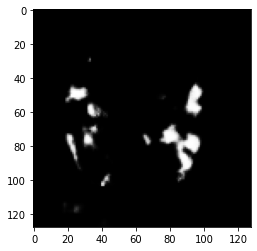

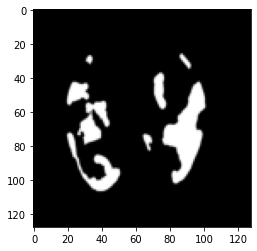

In [ ]:
import random
Ypred=model.predict(X_test)
rid=random.randint(0,Ypred.shape[0]-1)
plt.imshow(np.reshape(Ypred[rid],(128,128)), cmap=plt.cm.gray)
plt.show()
plt.imshow(np.reshape(Y_test[rid],(128,128)), cmap=plt.cm.gray)
plt.show()

In [ ]:
def dice(true_mask, pred_mask):
    """
        Computes the Dice coefficient.
        Args:
            true_mask : Array of arbitrary shape.
            pred_mask : Array with the same shape than true_mask.  
        
        Returns:
            A scalar representing the Dice coefficient between the two segmentations. 
        
    """
    non_seg_score=1.0
    if type(pred_mask) != np.ndarray:
      t = torch.Tensor([0.5])
      pred_mask=(pred_mask > t)
    else:
      pred_mask[pred_mask>=0.5]=1
      pred_mask[pred_mask<0.5]=0

    # If both segmentations are all zero, the dice will be 1. (Developer decision)
    im_sum = true_mask.sum() + pred_mask.sum()
    if im_sum == 0:
        return non_seg_score

    # Compute Dice coefficient
    intersection = np.logical_and(true_mask, pred_mask)
    return 2. * intersection.sum() / im_sum

In [ ]:
diceaux=dice(Y_test[160],Ypred[160])
diceaux

0.9357399154707194

## Model Fit Kfold

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [ ]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

25 epochs

In [ ]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=25,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.010589624755084515; accuracy of 98.96852374076843% DiceMetric of 90.11987447738647%
Score for fold 2: loss of 0.017074687406420708; accuracy of 98.8399863243103% DiceMetric of 88.72661590576172%
Score for fold 3: loss of 0.019004367291927338; accuracy of 98.89352321624756% DiceMetric of 85.86874604225159%
Score for fold 4: loss of 0.021750498563051224; accuracy of 98.8770842552185% DiceMetric of 87.11013793945312%
Score for fold 5: loss of 0.02564629353582859; accuracy of 98.92171621322632% DiceMetric of 84.32435989379883%


In [ ]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(metadat,metadat):
  model = create_model()
  for i,x in enumerate(train_index):
    size=metadat[x][1]
    ri=metadat[x][2]
    if i == 0:
      X_fold=X[ri:ri+size]
      Y_fold=Y[ri:ri+size]
    else:
      X_fold=np.concatenate((X_fold,X[ri:ri+size]),axis=0)
      Y_fold=np.concatenate((Y_fold,Y[ri:ri+size]),axis=0)
  for i,x in enumerate(val_index):
    size=metadat[x][1]
    ri=metadat[x][2]
    if i == 0:
      Xtest_fold=X[ri:ri+size]
      Ytest_fold=Y[ri:ri+size]
    else:
      Xtest_fold=np.concatenate((Xtest_fold,X[ri:ri+size]),axis=0)
      Ytest_fold=np.concatenate((Ytest_fold,Y[ri:ri+size]),axis=0)

  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=25,verbose=0)

  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')

Score for fold 1: loss of 0.005324899218976498; accuracy of 99.5372474193573% DiceMetric of 42.12750792503357%
Score for fold 1: loss of 0.024395179003477097; accuracy of 98.28765392303467% DiceMetric of 52.39614248275757%
Score for fold 1: loss of 0.021177247166633606; accuracy of 98.77491593360901% DiceMetric of 41.878390312194824%
Score for fold 1: loss of 0.030100753530859947; accuracy of 97.71497249603271% DiceMetric of 57.58134126663208%
Score for fold 1: loss of 0.04715128615498543; accuracy of 98.46388101577759% DiceMetric of 30.85877299308777%


In [ ]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(metadat,metadat):
  model = create_model()
  for i,x in enumerate(train_index):
    size=metadat[x][1]
    ri=metadat[x][2]
    if i == 0:
      X_fold=X[ri:ri+size]
      Y_fold=Y[ri:ri+size]
    else:
      X_fold=np.concatenate((X_fold,X[ri:ri+size]),axis=0)
      Y_fold=np.concatenate((Y_fold,Y[ri:ri+size]),axis=0)
  for i,x in enumerate(val_index):
    size=metadat[x][1]
    ri=metadat[x][2]
    if i == 0:
      Xtest_fold=X[ri:ri+size]
      Ytest_fold=Y[ri:ri+size]
    else:
      Xtest_fold=np.concatenate((Xtest_fold,X[ri:ri+size]),axis=0)
      Ytest_fold=np.concatenate((Ytest_fold,Y[ri:ri+size]),axis=0)

  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=25,verbose=0)

  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')

Score for fold 1: loss of 0.005309466738253832; accuracy of 99.54627752304077% DiceMetric of 41.23751223087311%
Score for fold 1: loss of 0.02331027388572693; accuracy of 98.27497005462646% DiceMetric of 53.798168897628784%
Score for fold 1: loss of 0.024359682574868202; accuracy of 98.72991442680359% DiceMetric of 41.83901846408844%
Score for fold 1: loss of 0.025078967213630676; accuracy of 98.13305139541626% DiceMetric of 65.87681174278259%
Score for fold 1: loss of 0.015188219025731087; accuracy of 99.03878569602966% DiceMetric of 40.995147824287415%


50 epochs

In [ ]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=50,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.016142617911100388; accuracy of 98.95281195640564% DiceMetric of 86.89823746681213%
Score for fold 2: loss of 0.02502174861729145; accuracy of 98.81399273872375% DiceMetric of 86.29720211029053%
Score for fold 3: loss of 0.029437260702252388; accuracy of 98.87399077415466% DiceMetric of 82.6685905456543%
Score for fold 4: loss of 0.027194472029805183; accuracy of 98.87163639068604% DiceMetric of 86.16846203804016%
Score for fold 5: loss of 0.029874801635742188; accuracy of 98.91415238380432% DiceMetric of 83.36634039878845%
